### Dataset Labeler

This notebook is used to label a raw fake dataset.

In [35]:
from pathlib import Path
import re
import sys
from collections import namedtuple
import random
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Plotting options for notebook
%matplotlib notebook
import matplotlib.pyplot as plt

# Make sure we can use GPU
use_gpu = torch.cuda.is_available()
print('Gpu is enabled: %s' % use_gpu)
dtype = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor

# Add local directories to path, get dataset utils
ROOT_DIR = Path.cwd()
sys.path.append(str(ROOT_DIR))
from data_utils import load_single_image

Gpu is enabled: True


## Load Images

In [53]:
def bounding_box(image, default_color=(255, 0, 255)):
    # Change default color pixels to zero
    for i in range(image.size[0]):
        for j in range(image.size[1]):
            if image.getpixel((i,j)) == default_color:
                image.putpixel((i, j), (0,0,0))
    # use PIL function to get bounding box over non-zero
    left, upper, right, lower  = image.getbbox()
    return [left, upper, right, lower]

def plot_image(image, draw_bbox=False):
    """
    Plots an image and prints out some info
    :param image: (PILImage) image to plot
    """
    fig = plt.figure()
    plt.tight_layout()
    if draw_bbox:
        from PIL import ImageDraw
        box = bounding_box(image)
        print('bounding box', box)
        draw = ImageDraw.Draw(image)
        draw.rectangle(box)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def load_single_image(image_path, imsize, **kwargs):
    """
    Loads a single image from file
    :param image_path: (string) filepath for image
    :param imsize: (tuple) desired image size
    :return: (Variable) image tensor
    """
    # Scales to image size and converts to tensor
    loader = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor()])
    img = Image.open(image_path)
    # Strip out 4th channel
    img_array = np.array(img)
    img_stripped = img_array[:, :, :3]
    img = Image.fromarray(img_stripped)
    if kwargs.get('plot', False):
        plot_image(img, draw_bbox=True)
    img = add_background(img, imsize)
    plot_image(img)
    img_tensor = Variable(loader(img))
    # Fake a batch dimension
    img_tensor = img_tensor.unsqueeze(0)
    if kwargs.get('use_gpu', False):
        img_tensor = img_tensor.cuda()
    return img, img_tensor

def add_background(image, imsize):
    background_img = Image.open(str(random.choice(room_image_path)))
    background_loader = transforms.Compose([
        transforms.RandomCrop(imsize)
    ])
    background_img = background_loader(background_img)
    background_img.paste(image)
    return background_img
    

<IPython.core.display.Javascript object>


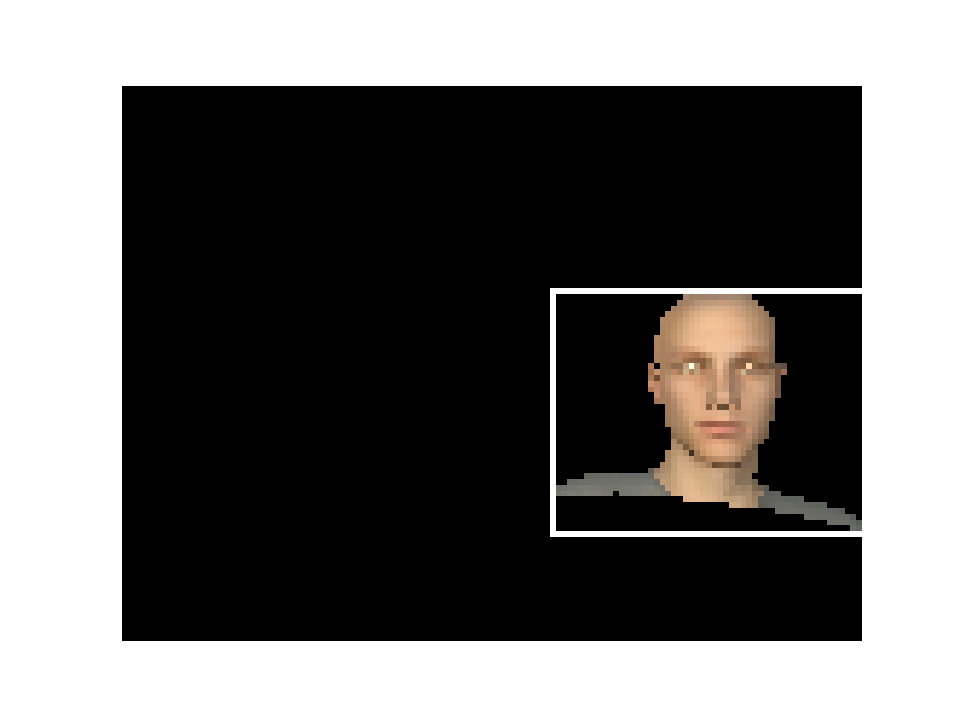

bounding box [74, 35, 128, 77]


<IPython.core.display.Javascript object>


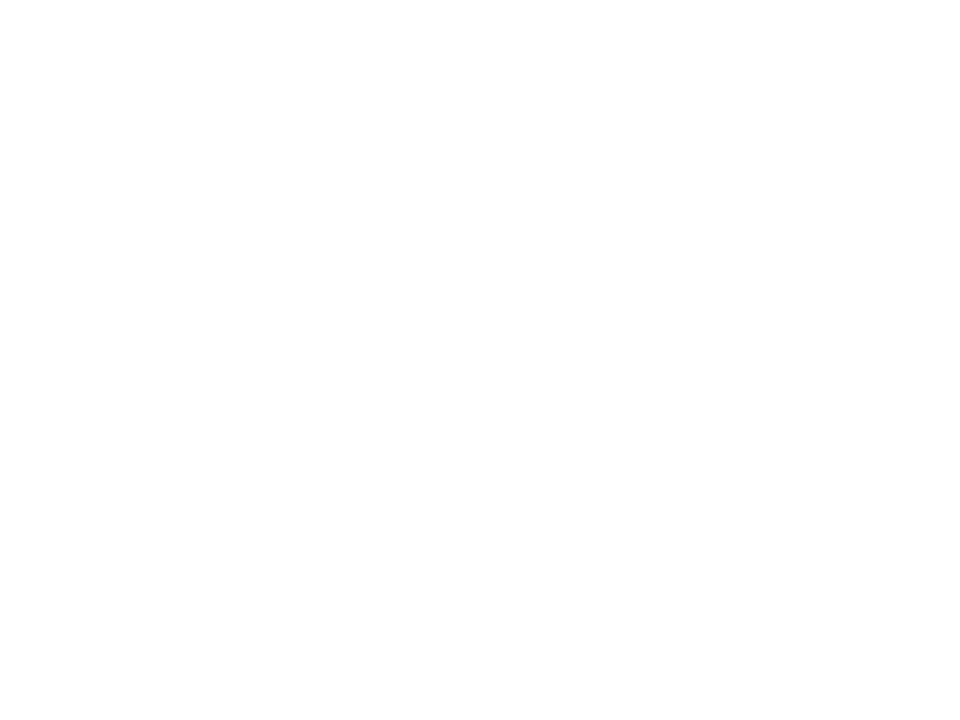

In [54]:
# Local dataset directory
data_dir = ROOT_DIR / '..' /  'data'

fake_dataset_path = data_dir / '26022018_0641'
room_dataset_path = data_dir / 'livingroom'

# grab random images
fake_image_path = str(list(fake_dataset_path.glob('*.png'))[0])
room_image_path = list(room_dataset_path.glob('*.jpg'))


fake_image, fake_image_tensor = load_single_image(fake_image_path, (96, 128), plot=True)

## Get bounding box from mask image